# Import Libararies

In [1]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from prettytable import PrettyTable
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from keras.callbacks import EarlyStopping

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout , BatchNormalization
from keras.utils.vis_utils import plot_model
model=Sequential()
model.add(Conv2D(64,(3,3),input_shape=(256,256,1),activation="relu",padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64,activation="relu"))

model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(64,activation="relu"))

model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(32,activation="relu"))


model.add(Dense(3,activation="softmax"))

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

NameError: name 'model' is not defined

# Check GPU detected

In [2]:
print(tf.__version__) # Check Enviroment Variable CUDA_VISIBLE_DEVICES
print(tf.config.list_physical_devices()) # Check in the terminal using nvidia-smi to monitor usage

2.5.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Convert the dataset into numpy arrays, or retrieve pickled objects

In [3]:
train=r"C:\endgame"
category=["healthypng","covidpng","pneumoniapng"]
data=[]
Model="CT"
for i in category:
    path=os.path.join(train,i)
    label=category.index(i)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        img_arr=cv2.imread(img_path,0)
        data.append([img_arr,label])
random.shuffle(data)
x=[]
y=[]
x_test=[]
y_test=[]
for features,labels in data:
    x.append(features)
    y.append(labels)
    
x_test=np.array(x[int(len(x)*0.9):-1])
y_test=np.array(y[int(len(y)*0.9):-1])

x=np.array(x[0:int(0.9*len(x))])
y=np.array(y[0:int(0.9*len(y))])

x=x/255
x_test=x_test/255

data.clear()

x=x.reshape(len(x),256,256,1)
x_test=x_test.reshape(len(x_test),256,256,1)

# Increase Page file size if Memory_Error occurs

In [4]:
pickle.dump(x,open('x4.pkl','wb'))
pickle.dump(y,open('y4.pkl','wb'))
pickle.dump(x_test,open('x_test4.pkl','wb'))
pickle.dump(y_test,open('y_test4.pkl','wb'))

In [3]:
x=pickle.load(open('x4.pkl','rb'))
x_test=pickle.load(open('x_test4.pkl','rb'))
y=pickle.load(open('y4.pkl','rb'))
y_test=pickle.load(open('y_test4.pkl','rb'))

# Build the CNet

In [5]:
def Train():
    # To prevent Resources_Exausted_Error
    gpu_options=tf.compat.v1.GPUOptions(allow_growth=True)
    config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)
    config.gpu_options.per_process_gpu_memory_fraction = 0.99
    session = tf.compat.v1.InteractiveSession(config=config)

    model=tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(64,(3,3),input_shape=x.shape[1:],activation="relu",padding="same"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64,activation="relu"))
    
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(64,activation="relu"))
   
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(32,activation="relu"))
   

    model.add(tf.keras.layers.Dense(3,activation="softmax"))


    model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['acc']) # or binary_crossentropy

    es=EarlyStopping(monitor='val_loss')
    
    model.fit(x,y,epochs=5,validation_split=0.1,batch_size=32)
    try:
        session.close()
    except:
        print('meh')

    return model

In [18]:
#model=Train()

loss,win=model.evaluate(x_test,y_test)
print('===============================================================')
print('loss: {}, acc: {}'.format(loss,win))

model.summary()

  2/119 [..............................] - ETA: 8s - loss: 0.1641 - acc: 0.9688 C:\Users\omara\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
119/119 [==============================] - 8s 66ms/step - loss: 0.2053 - acc: 0.9176
loss: 0.20529457926750183, acc: 0.9176346063613892
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D) 

# Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(x, y)

y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

# Saving the model after achieving 95% accuracy

In [7]:
model.save("ULT_CT_XRAY_CONV_V6")

INFO:tensorflow:Assets written to: ULT_CT_XRAY_CONV_V5\assets


In [15]:
model=tf.keras.models.load_model("ULT_CT_XRAY_CONV_V6")

# Transfer Learning Applied

In [13]:
tune=r"C:\tune"
transfer=r"C:\transfer"
category=["healthypng","covidpng","pneumoniapng"]
data=[]
Model="CT"
tunedata=[]
transferdata=[]
for i in category:
    path1=os.path.join(tune,i)
    path2=os.path.join(transfer,i)
    label=category.index(i)
    for img in os.listdir(path1):
        img_path=os.path.join(path1,img)
        img_arr=cv2.imread(img_path,0)
        tunedata.append([img_arr,label])
    for img in os.listdir(path2):
        img_path=os.path.join(path2,img)
        img_arr=cv2.imread(img_path,0)
        transferdata.append([img_arr,label])
random.shuffle(transferdata)
random.shuffle(tunedata)
tune_img,tune_lbl=[],[]
transfer_img,transfer_lbl=[],[]
for features,labels in tunedata:
    tune_img.append(features)
    tune_lbl.append(labels)
for features,labels in transferdata:
    transfer_img.append(features)
    transfer_lbl.append(labels)
tune_img=np.array(tune_img)
tune_lbl=np.array(tune_lbl)

transfer_img=np.array(transfer_img)
transfer_lbl=np.array(transfer_lbl)

tune_img=tune_img/255
transfer_img=transfer_img/255

tunedata.clear()
transferdata.clear()

tune_img=tune_img.reshape(len(tune_img),256,256,1)
transfer_img=transfer_img.reshape(len(transfer_img),256,256,1)

# Fine tunning and freezing layers

In [16]:
model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 12
fine_tune_epochs = 3
# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  13


# Compile

In [17]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['acc']) # or binary_crossentropy

es=EarlyStopping(monitor='val_loss')
    
model.fit(tune_img,tune_lbl,epochs=6,batch_size=32)

C:\Users\omara\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
Epoch 1/6
3/3 [==============================] - 35s 283ms/step - loss: 0.6029 - acc: 0.7083
Epoch 2/6
3/3 [==============================] - 1s 265ms/step - loss: 0.5744 - acc: 0.7083
Epoch 3/6
3/3 [==============================] - 1s 264ms/step - loss: 0.4959 - acc: 0.7604
Epoch 4/6
3/3 [==============================] - 1s 256ms/step - loss: 0.5275 - acc: 0.7604
Epoch 5/6
3/3 [==============================] - 1s 253ms/step - loss: 0.5271 - acc: 0.7188
Epoch 6/6
3/3 [==============================] - 1s 251ms/step - loss: 0.4527 - acc: 0.7708


# Test Using transfer learning

In [18]:
loss,win=model.evaluate(transfer_img,transfer_lbl)
print('===============================================================')
print('loss: {}, acc: {}'.format(loss,win))

13/13 [==============================] - 1s 79ms/step - loss: 0.3549 - acc: 0.8614
loss: 0.35491621494293213, acc: 0.8613861203193665


# Test on our original dataset to make sure our learned varaiable has not been destroyed

In [11]:

loss,win=model.evaluate(x_test,y_test)
print('===============================================================')
print('loss: {}, acc: {}'.format(loss,win))

119/119 [==============================] - 6s 48ms/step - loss: 0.2253 - acc: 0.9023
loss: 0.22532135248184204, acc: 0.9023231267929077


# Confusion Matrix for model after transfer learning

True


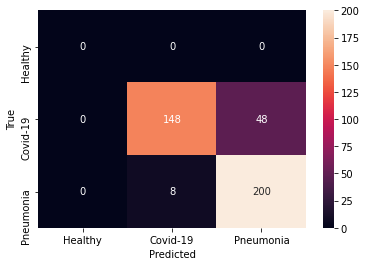

In [19]:
singlepredict=[]
singletest=[]
predict=model.predict([transfer_img]) # not the best way to get a some neat labels
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())# If false then confusion.numpy will produce error

singlepredict=np.argmax(predict,1) # I forget what it does exactly or how it does it
singletest=np.array(transfer_lbl)
confusion=tf.math.confusion_matrix(labels=singletest, predictions=singlepredict).numpy()
#plt.imshow(confusion) # Green Confusion Matrix
sns.heatmap(confusion , annot=True , xticklabels=['Healthy' ,'Covid-19','Pneumonia'] , yticklabels=['Healthy' , 'Covid-19','Pneumonia'],fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Metrics

In [13]:
precision, recall, f1, _ = score(singletest, singlepredict)
print('Precision: {},Averge: {}'.format(precision,sum(precision)/len(precision)))
print('Recall: {},Average: {}'.format(recall,sum(recall)/len(recall)))
print('F-score: {},Average: {}'.format(f1,sum(f1)/len(f1)))

Precision: [0.94871795 0.80645161],Averge: 0.8775847808105872
Recall: [0.75510204 0.96153846],Average: 0.858320251177394
F-score: [0.84090909 0.87719298],Average: 0.8590510366826156


# Save fine tuned model

In [ ]:
model.save("ULT_CT_XRAY_CONV_V7_FINED")

# Strandradized Table for the model acuuaracy and after 30 runs.

In [ ]:
for i in range(30):
    model=Train()
    test=model.evaluate(x_test,y_test)
    with open(r'avg.txt','a+') as file:
        file.write("{},{}\n".format(test[1],test[0]))

# Confusion Matrix 

C:\Users\omara\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
True


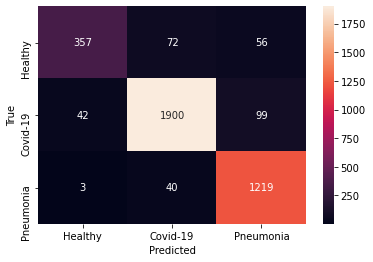

In [8]:
singlepredict=[]
singletest=[]
predict=model.predict([x_test]) # not the best way to get a some neat labels
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())# If false then confusion.numpy will produce error

singlepredict=np.argmax(predict,1) # I forget what it does exactly or how it does it
singletest=np.array(y_test)
confusion=tf.math.confusion_matrix(labels=singletest, predictions=singlepredict).numpy()
#plt.imshow(confusion) # Green Confusion Matrix
sns.heatmap(confusion , annot=True , xticklabels=['Healthy' , 'Covid-19','Pneumonia'] , yticklabels=['Healthy' , 'Covid-19','Pneumonia'],fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Metrics

In [17]:
precision, recall, f1, _ = score(singletest, singlepredict)
print('Precision: {},Average: {}'.format(precision,sum(precision)/len(precision)))
print('Recall: {},Average: {}'.format(recall,sum(recall)/len(recall)))
print('F-score: {},Average: {}'.format(f1,sum(f1)/len(f1)))


Precision: [0.8880597  0.944334   0.88719068],Average: 0.9065281272167699
Recall: [0.73608247 0.93091622 0.9659271 ],Average: 0.877641930536249
F-score: [0.80496054 0.9375771  0.92488619],Average: 0.889141278576314


In [10]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
val_loss = model.history.history['val_loss']
loss = model.history.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, [i*100 for i in acc], 'green', label='Training acc')
plt.plot(epochs,[i*100 for i in val_acc], 'blue', label='Validation acc')

plt.plot(epochs, [i*100 for i in loss], 'red', label='Training loss')
plt.plot(epochs,[i*100 for i in val_loss], 'black', label='Validation loss')
plt.title('Training, validation accuaracy and loss over epochs')#'Training and validation loss'
plt.legend()

plt.show()

KeyError: 'acc'

# Some visulization into some cases in the dataset, the prediction and the true output.

In [8]:
predict=model.predict([x_test])

C:\Users\omara\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


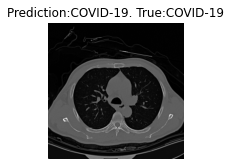

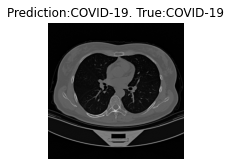

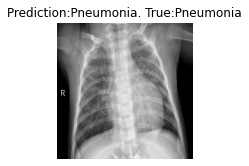

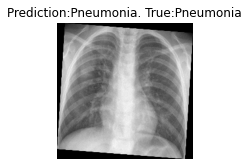

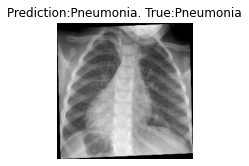

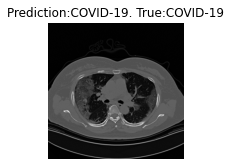

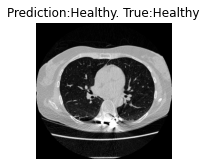

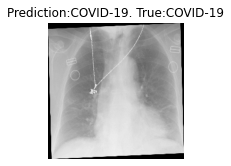

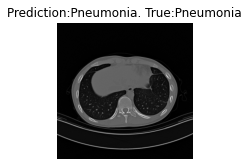

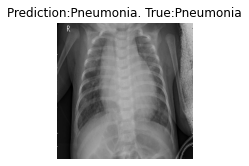

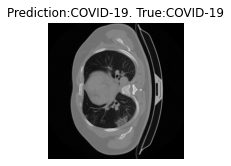

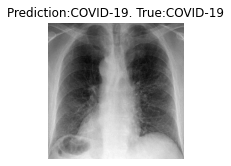

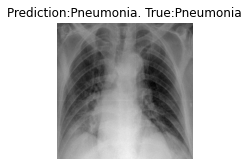

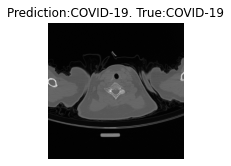

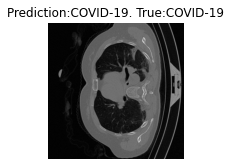

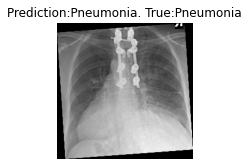

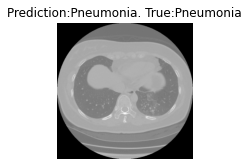

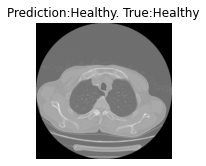

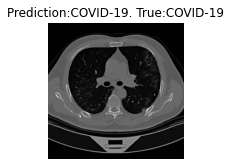

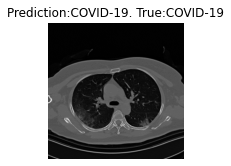

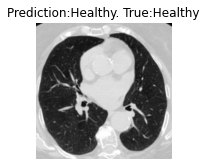

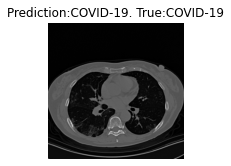

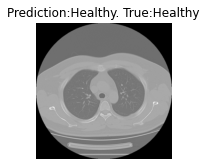

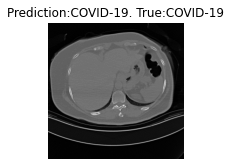

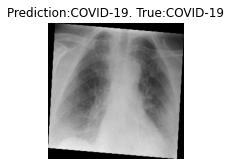

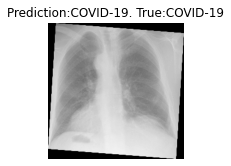

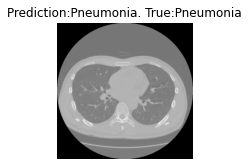

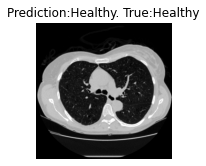

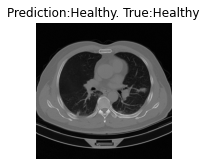

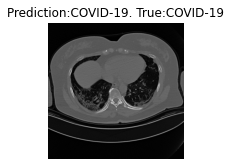

In [13]:
def simpleargmax(n):
    if list(n).index(max(n))==0:
        return "Healthy"
    elif list(n).index(max(n))==1:
        return "COVID-19"
    else:
        return "Pneumonia"
def label(m):
    if m==0:
        return "Healthy"
    elif m==1:
        return "COVID-19"
    else:
        return "Pneumonia"
for i in range(30):
    plt.figure(figsize = (2.5,2.5))
    val=random.randint(0,len(x_test)-1)
    plt.axis("off")
    plt.imshow(x_test[val], cmap='gray')
    plt.title("Prediction:{}. True:{}".format(simpleargmax(predict[val]),label(y_test[val])))
    plt.show()